In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms
from data_poisoning import MixedDatasetPreComputed, MixedDataset, load_trigger_tensor
from tqdm import tqdm
from evaluation import evaluate_model, print_metrics
from models import PretrainedVGG16Autoencoder
from torchvision.models import vgg16

BATCH_SIZE = 128
TEST_BATCH_SIZE = 64
VIZ_BATCH_SIZE = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Instantiate data loaders
trigger_tensor = load_trigger_tensor("./triggers/trigger.png")

train_pre_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
test_pre_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)


train_dataset = MixedDatasetPreComputed(train_pre_dataset, trigger_tensor, scale_factor=0.2)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = MixedDatasetPreComputed(test_pre_dataset, trigger_tensor, scale_factor=0.2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

viz_loader = torch.utils.data.DataLoader(test_dataset, batch_size=VIZ_BATCH_SIZE, shuffle=True)


100%|██████████| 10000/10000 [00:16<00:00, 591.71it/s]


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, stride=2, padding=1),  # 8x8 -> 4x4
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1024 * 4 * 4, 2048),
            nn.ReLU(),
            nn.Linear(2048, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (1024, 4, 4)),
            nn.ConvTranspose2d(1024, 1024, kernel_size=3, stride=2, padding=1, output_padding=1),  # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16x16 -> 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # Output in range [0, 1]
        )


    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent

# Training and evaluation setup
def train_autoencoder(autoencoder, train_loader, criterion, optimizer, num_epochs, device):
    autoencoder.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for images, _, _, _ in tqdm(train_loader):  # We only care about images
            images = images.to(device)

            # Forward pass
            reconstructed, _ = autoencoder(images)
            loss = criterion(reconstructed, images)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * images.size(0)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader.dataset):.4f}")


In [4]:
from torchsummary import summary

LATENT_DIM = 1024
NUM_EPOCHS = 30
LEARNING_RATE = 0.0001
BATCH_SIZE = 128
TEST_BATCH_SIZE = 256
VIZ_BATCH_SIZE = 512

autoencoder = Autoencoder(latent_dim=LATENT_DIM).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE)

summary(autoencoder, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]          73,856
              ReLU-4          [-1, 128, 16, 16]               0
            Conv2d-5          [-1, 256, 16, 16]         295,168
              ReLU-6          [-1, 256, 16, 16]               0
            Conv2d-7            [-1, 512, 8, 8]       1,180,160
              ReLU-8            [-1, 512, 8, 8]               0
            Conv2d-9           [-1, 1024, 8, 8]       4,719,616
             ReLU-10           [-1, 1024, 8, 8]               0
           Conv2d-11           [-1, 1024, 4, 4]       9,438,208
             ReLU-12           [-1, 1024, 4, 4]               0
          Flatten-13                [-1, 16384]               0
           Linear-14                 [-

In [5]:
train_autoencoder(autoencoder, train_loader, criterion, optimizer, 60, DEVICE)

100%|██████████| 782/782 [01:57<00:00,  6.67it/s]


Epoch [1/60], Loss: 0.0359


100%|██████████| 782/782 [01:56<00:00,  6.73it/s]


Epoch [2/60], Loss: 0.0180


100%|██████████| 782/782 [01:55<00:00,  6.75it/s]


Epoch [3/60], Loss: 0.0138


100%|██████████| 782/782 [01:56<00:00,  6.71it/s]


Epoch [4/60], Loss: 0.0121


100%|██████████| 782/782 [01:55<00:00,  6.80it/s]


Epoch [5/60], Loss: 0.0110


100%|██████████| 782/782 [01:57<00:00,  6.67it/s]


Epoch [6/60], Loss: 0.0102


100%|██████████| 782/782 [01:56<00:00,  6.69it/s]


Epoch [7/60], Loss: 0.0096


100%|██████████| 782/782 [01:56<00:00,  6.69it/s]


Epoch [8/60], Loss: 0.0089


100%|██████████| 782/782 [01:56<00:00,  6.70it/s]


Epoch [9/60], Loss: 0.0083


100%|██████████| 782/782 [01:56<00:00,  6.69it/s]


Epoch [10/60], Loss: 0.0077


100%|██████████| 782/782 [01:56<00:00,  6.73it/s]


Epoch [11/60], Loss: 0.0072


100%|██████████| 782/782 [01:56<00:00,  6.73it/s]


Epoch [12/60], Loss: 0.0069


100%|██████████| 782/782 [01:56<00:00,  6.70it/s]


Epoch [13/60], Loss: 0.0065


100%|██████████| 782/782 [01:56<00:00,  6.70it/s]


Epoch [14/60], Loss: 0.0062


100%|██████████| 782/782 [01:57<00:00,  6.67it/s]


Epoch [15/60], Loss: 0.0058


100%|██████████| 782/782 [01:56<00:00,  6.69it/s]


Epoch [16/60], Loss: 0.0056


100%|██████████| 782/782 [01:57<00:00,  6.68it/s]


Epoch [17/60], Loss: 0.0053


100%|██████████| 782/782 [01:56<00:00,  6.71it/s]


Epoch [18/60], Loss: 0.0051


100%|██████████| 782/782 [01:57<00:00,  6.67it/s]


Epoch [19/60], Loss: 0.0048


100%|██████████| 782/782 [01:56<00:00,  6.69it/s]


Epoch [20/60], Loss: 0.0046


100%|██████████| 782/782 [01:57<00:00,  6.65it/s]


Epoch [21/60], Loss: 0.0044


100%|██████████| 782/782 [01:56<00:00,  6.69it/s]


Epoch [22/60], Loss: 0.0042


100%|██████████| 782/782 [01:56<00:00,  6.70it/s]


Epoch [23/60], Loss: 0.0040


100%|██████████| 782/782 [01:56<00:00,  6.70it/s]


Epoch [24/60], Loss: 0.0038


100%|██████████| 782/782 [01:56<00:00,  6.70it/s]


Epoch [25/60], Loss: 0.0037


100%|██████████| 782/782 [01:56<00:00,  6.72it/s]


Epoch [26/60], Loss: 0.0035


100%|██████████| 782/782 [01:57<00:00,  6.68it/s]


Epoch [27/60], Loss: 0.0034


100%|██████████| 782/782 [01:56<00:00,  6.73it/s]


Epoch [28/60], Loss: 0.0032


100%|██████████| 782/782 [01:56<00:00,  6.73it/s]


Epoch [29/60], Loss: 0.0031


100%|██████████| 782/782 [01:55<00:00,  6.80it/s]


Epoch [30/60], Loss: 0.0030


100%|██████████| 782/782 [01:54<00:00,  6.82it/s]


Epoch [31/60], Loss: 0.0029


100%|██████████| 782/782 [01:54<00:00,  6.80it/s]


Epoch [32/60], Loss: 0.0028


100%|██████████| 782/782 [01:54<00:00,  6.83it/s]


Epoch [33/60], Loss: 0.0027


100%|██████████| 782/782 [01:54<00:00,  6.85it/s]


Epoch [34/60], Loss: 0.0026


100%|██████████| 782/782 [01:54<00:00,  6.82it/s]


Epoch [35/60], Loss: 0.0025


100%|██████████| 782/782 [01:54<00:00,  6.82it/s]


Epoch [36/60], Loss: 0.0025


100%|██████████| 782/782 [01:54<00:00,  6.82it/s]


Epoch [37/60], Loss: 0.0024


100%|██████████| 782/782 [01:54<00:00,  6.85it/s]


Epoch [38/60], Loss: 0.0023


100%|██████████| 782/782 [01:54<00:00,  6.83it/s]


Epoch [39/60], Loss: 0.0023


100%|██████████| 782/782 [01:54<00:00,  6.84it/s]


Epoch [40/60], Loss: 0.0022


100%|██████████| 782/782 [01:54<00:00,  6.82it/s]


Epoch [41/60], Loss: 0.0021


100%|██████████| 782/782 [01:54<00:00,  6.83it/s]


Epoch [42/60], Loss: 0.0021


100%|██████████| 782/782 [01:54<00:00,  6.84it/s]


Epoch [43/60], Loss: 0.0020


100%|██████████| 782/782 [01:54<00:00,  6.83it/s]


Epoch [44/60], Loss: 0.0020


100%|██████████| 782/782 [01:54<00:00,  6.83it/s]


Epoch [45/60], Loss: 0.0019


100%|██████████| 782/782 [01:54<00:00,  6.84it/s]


Epoch [46/60], Loss: 0.0019


100%|██████████| 782/782 [01:54<00:00,  6.83it/s]


Epoch [47/60], Loss: 0.0018


100%|██████████| 782/782 [01:54<00:00,  6.83it/s]


Epoch [48/60], Loss: 0.0018


100%|██████████| 782/782 [01:54<00:00,  6.82it/s]


Epoch [49/60], Loss: 0.0018


100%|██████████| 782/782 [01:54<00:00,  6.83it/s]


Epoch [50/60], Loss: 0.0017


100%|██████████| 782/782 [01:53<00:00,  6.86it/s]


Epoch [51/60], Loss: 0.0017


100%|██████████| 782/782 [01:53<00:00,  6.87it/s]


Epoch [52/60], Loss: 0.0017


100%|██████████| 782/782 [01:54<00:00,  6.85it/s]


Epoch [53/60], Loss: 0.0016


100%|██████████| 782/782 [01:54<00:00,  6.84it/s]


Epoch [54/60], Loss: 0.0016


100%|██████████| 782/782 [01:54<00:00,  6.84it/s]


Epoch [55/60], Loss: 0.0016


100%|██████████| 782/782 [01:54<00:00,  6.83it/s]


Epoch [56/60], Loss: 0.0015


100%|██████████| 782/782 [01:54<00:00,  6.84it/s]


Epoch [57/60], Loss: 0.0015


100%|██████████| 782/782 [01:54<00:00,  6.82it/s]


Epoch [58/60], Loss: 0.0015


100%|██████████| 782/782 [01:54<00:00,  6.83it/s]


Epoch [59/60], Loss: 0.0015


100%|██████████| 782/782 [01:54<00:00,  6.83it/s]

Epoch [60/60], Loss: 0.0014


In [17]:
from copy import deepcopy

autoencoder2 = autoencoder
optimizer = torch.optim.Adam(autoencoder2.parameters(), lr=0.000001)

train_autoencoder(autoencoder2, train_loader=train_loader, criterion=criterion, optimizer=optimizer, num_epochs=60, device=DEVICE)

100%|██████████| 782/782 [01:54<00:00,  6.82it/s]


Epoch [1/60], Loss: 0.0009


100%|██████████| 782/782 [01:54<00:00,  6.83it/s]


Epoch [2/60], Loss: 0.0009


100%|██████████| 782/782 [01:54<00:00,  6.83it/s]


Epoch [3/60], Loss: 0.0009


100%|██████████| 782/782 [01:54<00:00,  6.82it/s]


Epoch [4/60], Loss: 0.0009


100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Epoch [5/60], Loss: 0.0009


100%|██████████| 782/782 [01:56<00:00,  6.72it/s]


Epoch [6/60], Loss: 0.0009


100%|██████████| 782/782 [01:56<00:00,  6.72it/s]


Epoch [7/60], Loss: 0.0009


100%|██████████| 782/782 [01:56<00:00,  6.73it/s]


Epoch [8/60], Loss: 0.0009


100%|██████████| 782/782 [01:56<00:00,  6.72it/s]


Epoch [9/60], Loss: 0.0009


100%|██████████| 782/782 [01:56<00:00,  6.73it/s]


Epoch [10/60], Loss: 0.0009


100%|██████████| 782/782 [01:56<00:00,  6.71it/s]


Epoch [11/60], Loss: 0.0009


100%|██████████| 782/782 [01:55<00:00,  6.76it/s]


Epoch [12/60], Loss: 0.0009


100%|██████████| 782/782 [01:56<00:00,  6.73it/s]


Epoch [13/60], Loss: 0.0009


100%|██████████| 782/782 [01:55<00:00,  6.76it/s]


Epoch [14/60], Loss: 0.0009


100%|██████████| 782/782 [01:56<00:00,  6.72it/s]


Epoch [15/60], Loss: 0.0009


100%|██████████| 782/782 [01:55<00:00,  6.76it/s]


Epoch [16/60], Loss: 0.0009


100%|██████████| 782/782 [01:55<00:00,  6.75it/s]


Epoch [17/60], Loss: 0.0009


100%|██████████| 782/782 [01:55<00:00,  6.75it/s]


Epoch [18/60], Loss: 0.0009


100%|██████████| 782/782 [01:55<00:00,  6.74it/s]


Epoch [19/60], Loss: 0.0009


100%|██████████| 782/782 [01:55<00:00,  6.76it/s]


Epoch [20/60], Loss: 0.0009


100%|██████████| 782/782 [01:56<00:00,  6.73it/s]


Epoch [21/60], Loss: 0.0009


100%|██████████| 782/782 [01:56<00:00,  6.74it/s]


Epoch [22/60], Loss: 0.0009


100%|██████████| 782/782 [01:55<00:00,  6.75it/s]


Epoch [23/60], Loss: 0.0009


100%|██████████| 782/782 [01:55<00:00,  6.74it/s]


Epoch [24/60], Loss: 0.0009


100%|██████████| 782/782 [01:55<00:00,  6.75it/s]


Epoch [25/60], Loss: 0.0009


100%|██████████| 782/782 [01:55<00:00,  6.75it/s]


Epoch [26/60], Loss: 0.0009


100%|██████████| 782/782 [01:55<00:00,  6.76it/s]


Epoch [27/60], Loss: 0.0009


100%|██████████| 782/782 [01:55<00:00,  6.74it/s]


Epoch [28/60], Loss: 0.0009


100%|██████████| 782/782 [01:55<00:00,  6.76it/s]


Epoch [29/60], Loss: 0.0009


100%|██████████| 782/782 [01:56<00:00,  6.73it/s]


Epoch [30/60], Loss: 0.0009


100%|██████████| 782/782 [01:55<00:00,  6.76it/s]


Epoch [31/60], Loss: 0.0009


100%|██████████| 782/782 [01:55<00:00,  6.76it/s]


Epoch [32/60], Loss: 0.0009


100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Epoch [33/60], Loss: 0.0009


100%|██████████| 782/782 [01:56<00:00,  6.73it/s]


Epoch [34/60], Loss: 0.0009


100%|██████████| 782/782 [01:55<00:00,  6.76it/s]


Epoch [35/60], Loss: 0.0009


100%|██████████| 782/782 [01:56<00:00,  6.73it/s]


Epoch [36/60], Loss: 0.0009


100%|██████████| 782/782 [01:55<00:00,  6.76it/s]


Epoch [37/60], Loss: 0.0009


100%|██████████| 782/782 [01:56<00:00,  6.73it/s]


Epoch [38/60], Loss: 0.0009


100%|██████████| 782/782 [01:55<00:00,  6.75it/s]


Epoch [39/60], Loss: 0.0009


100%|██████████| 782/782 [01:56<00:00,  6.74it/s]


Epoch [40/60], Loss: 0.0009


100%|██████████| 782/782 [01:55<00:00,  6.76it/s]


Epoch [41/60], Loss: 0.0009


100%|██████████| 782/782 [01:55<00:00,  6.74it/s]


Epoch [42/60], Loss: 0.0009


100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Epoch [43/60], Loss: 0.0009


100%|██████████| 782/782 [01:56<00:00,  6.73it/s]


Epoch [44/60], Loss: 0.0009


100%|██████████| 782/782 [01:55<00:00,  6.75it/s]


Epoch [45/60], Loss: 0.0009


100%|██████████| 782/782 [01:56<00:00,  6.73it/s]


Epoch [46/60], Loss: 0.0009


100%|██████████| 782/782 [01:55<00:00,  6.74it/s]


Epoch [47/60], Loss: 0.0009


100%|██████████| 782/782 [01:55<00:00,  6.75it/s]


Epoch [48/60], Loss: 0.0009


100%|██████████| 782/782 [01:56<00:00,  6.74it/s]


Epoch [49/60], Loss: 0.0009


100%|██████████| 782/782 [01:55<00:00,  6.74it/s]


Epoch [50/60], Loss: 0.0009


100%|██████████| 782/782 [01:56<00:00,  6.74it/s]


Epoch [51/60], Loss: 0.0009


100%|██████████| 782/782 [01:55<00:00,  6.75it/s]


Epoch [52/60], Loss: 0.0009


100%|██████████| 782/782 [01:56<00:00,  6.73it/s]


Epoch [53/60], Loss: 0.0009


100%|██████████| 782/782 [01:55<00:00,  6.75it/s]


Epoch [54/60], Loss: 0.0009


100%|██████████| 782/782 [01:56<00:00,  6.73it/s]


Epoch [55/60], Loss: 0.0009


100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Epoch [56/60], Loss: 0.0009


100%|██████████| 782/782 [01:56<00:00,  6.71it/s]


Epoch [57/60], Loss: 0.0009


100%|██████████| 782/782 [01:56<00:00,  6.74it/s]


Epoch [58/60], Loss: 0.0009


 42%|████▏     | 327/782 [00:48<01:08,  6.68it/s]


KeyboardInterrupt: 

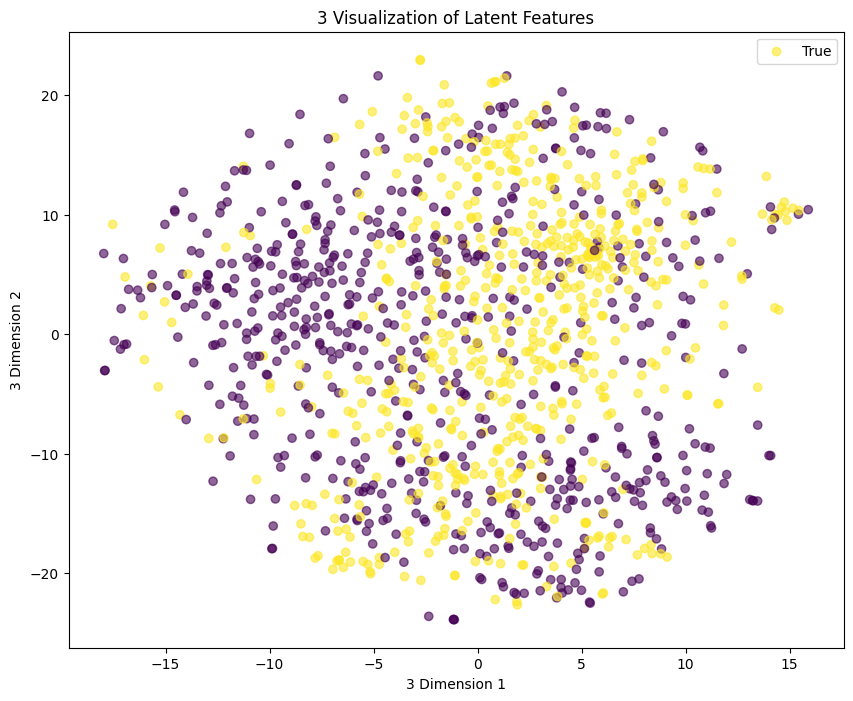

In [30]:
#import pca
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

class GroupingMethod():
    NONE = 1
    DBSCAN = 2
    KMeans = 3

class ReductionMethod():
    NONE = 1
    PCA = 2
    TSNE = 3

def vizualize_latent(autoencoder, loader, device, method=ReductionMethod.TSNE, grouping_method=GroupingMethod.NONE, class_no = None):
    autoencoder.eval()
    latent_features = []
    poison_labels = []

    with torch.no_grad():
        num_batches = 0
        for images, labels, _, poison in loader:
            if num_batches >= 100:
                break
            num_batches += 1

            if (class_no is not None):
                class_0_indices = (labels == class_no)
                images = images[class_0_indices].to(device)
                poison = poison[class_0_indices]
            else:
                images = images.to(device)

            if images.size(0) == 0:
                continue
            _, latent = autoencoder(images)
            latent_features.append(latent.cpu().numpy())
            poison_labels.append(poison.numpy())
    latent_features = np.concatenate(latent_features, axis=0)
    poison_labels = np.concatenate(poison_labels, axis=0)

    if grouping_method != GroupingMethod.NONE:
        if grouping_method == GroupingMethod.KMeans:
            kmeans = KMeans(n_clusters=2, random_state=42)
            cluster_labels = kmeans.fit_predict(latent_features)
            latent_features = np.column_stack((latent_features, cluster_labels))
        elif grouping_method == GroupingMethod.DBSCAN:
            dbscan = DBSCAN(eps=0.5, min_samples=5)
            cluster_labels = dbscan.fit_predict(latent_features)
            latent_features = np.column_stack((latent_features, cluster_labels))

    if method == ReductionMethod.PCA:
        results = PCA(n_components=2).fit_transform(latent_features)
    elif method == ReductionMethod.TSNE:
        results = TSNE(n_components=2, random_state=42).fit_transform(latent_features)

    plt.figure(figsize=(10, 8))
    if grouping_method != GroupingMethod.NONE:
        scatter = plt.scatter(results[:, 0], results[:, 1], c=results[:, 2], alpha=0.6)
    else: 
        scatter = plt.scatter(results[:, 0], results[:, 1], c=poison_labels, alpha=0.6)
    plt.legend(poison_labels)
    
    plt.title(f"{method} Visualization of Latent Features")
    plt.xlabel(f"{method} Dimension 1")
    plt.ylabel(f"{method} Dimension 2")
    plt.show()
    return


# Show 10 images reconstructed by the autoencoder
def show_reconstructed_images(autoencoder, viz_loader, device):
    autoencoder.eval()
    with torch.no_grad():
        for images, _, _, _ in viz_loader:
            images = images.to(device)
            reconstructed, _ = autoencoder(images)

            # Convert to numpy for visualization
            images = images.cpu().numpy().transpose(0, 2, 3, 1)  # NCHW -> NHWC
            reconstructed = reconstructed.cpu().numpy().transpose(0, 2, 3, 1)

            # Denormalize images
            images = (images * 0.5) + 0.5  # Assuming normalization range was [-1, 1]
            reconstructed = (reconstructed * 0.5) + 0.5

            # Plot 10 images
            fig, axes = plt.subplots(2, 10, figsize=(20, 4))
            for i in range(10):
                if i >= images.shape[0]:
                    break
                axes[0, i].imshow(images[i])
                axes[0, i].axis("off")
                axes[1, i].imshow(reconstructed[i])
                axes[1, i].axis("off")

            axes[0, 0].set_ylabel("Original", fontsize=12)
            axes[1, 0].set_ylabel("Reconstructed", fontsize=12)
            plt.show()
            break  # Show only one batch

vizualize_latent(autoencoder, train_loader, DEVICE, method=ReductionMethod.TSNE, grouping_method=GroupingMethod.NONE, class_no=5)

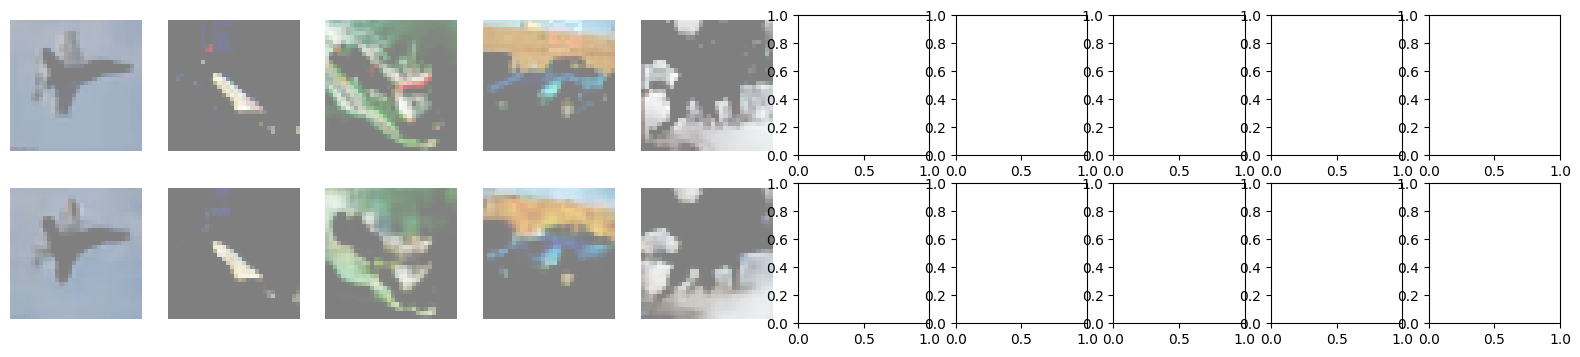

In [19]:
show_reconstructed_images(autoencoder, viz_loader, DEVICE)

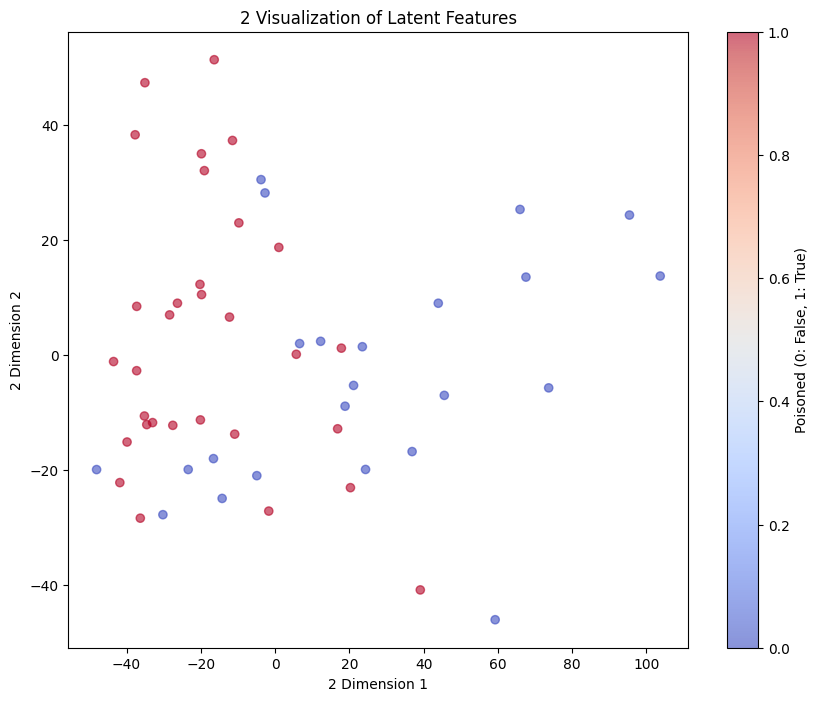

In [20]:
vizualize_latent(autoencoder, viz_loader, DEVICE, method=ReductionMethod.PCA)